In [43]:
import os
import librosa
import numpy as np
import random

# Path to your free-spoken-digit-dataset recordings
audio_dir = '/content/free-spoken-digit-dataset/recordings'

files = [os.path.join(audio_dir, f) for f in os.listdir(audio_dir) if f.endswith('.wav')]
print(f"Found {len(files)} spoken word files.")

# Correct pitch shift function
def pitch_shift(audio, sr, max_steps=4):
    steps = random.uniform(-max_steps, max_steps)
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=steps)



Found 3000 spoken word files.


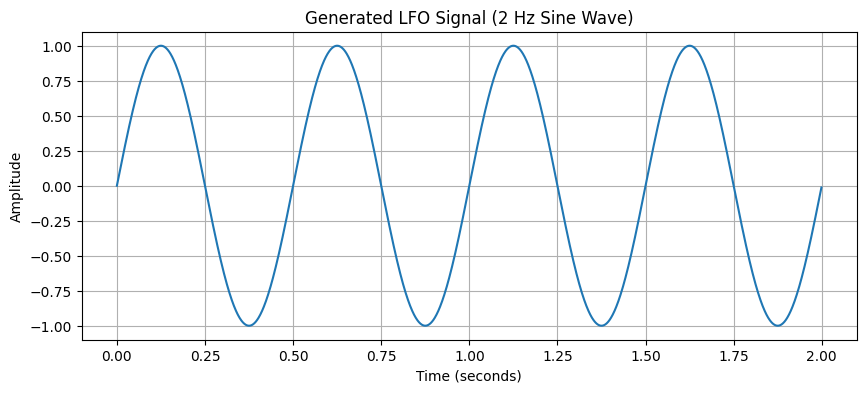

Base latent vector:
[ 0.43827883 -0.55650716 -0.68252608 -0.15677327  0.85364739  0.75327598
 -0.20526463  0.78138482]
Modulated latent vectors shape: (2000, 8)


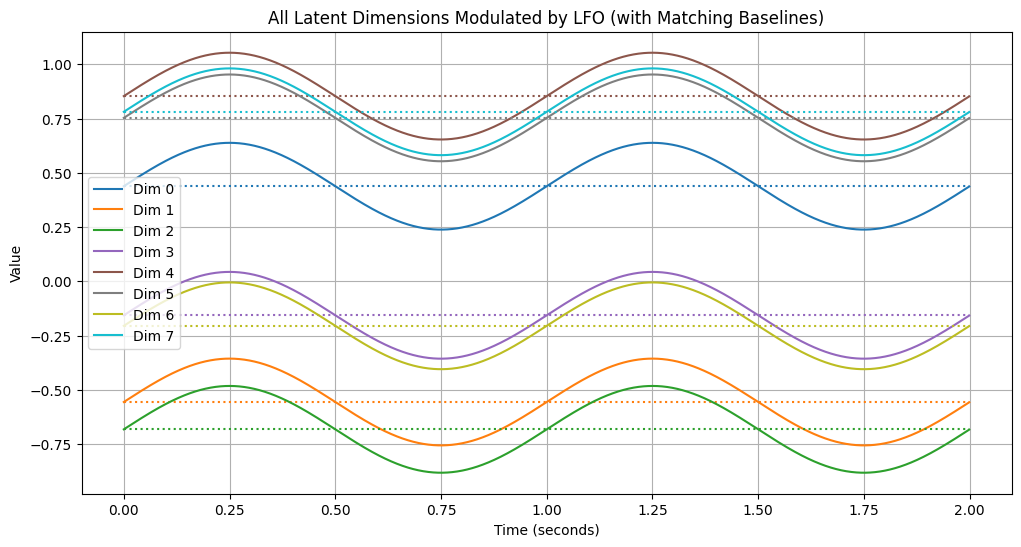

In [44]:
import matplotlib.pyplot as plt

class LFO:
    def __init__(self, rate=1.0, depth=1.0, sample_rate=1000, waveform='sine'):
        self.rate = rate  # Frequency in Hz
        self.depth = depth  # Amplitude
        self.sample_rate = sample_rate  # Samples per second
        self.waveform = waveform

    def generate(self, duration=1.0):
        t = np.linspace(0, duration, int(self.sample_rate * duration), endpoint=False)
        if self.waveform == 'sine':
            signal = np.sin(2 * np.pi * self.rate * t)
        elif self.waveform == 'triangle':
            signal = 2 * np.abs(2 * (t * self.rate - np.floor(t * self.rate + 0.5))) - 1
        elif self.waveform == 'square':
            signal = np.sign(np.sin(2 * np.pi * self.rate * t))
        elif self.waveform == 'sawtooth':
            signal = 2 * (t * self.rate - np.floor(0.5 + t * self.rate))
        elif self.waveform == 'random':
            signal = np.random.uniform(-1, 1, len(t))
        else:
            raise ValueError(f"Unsupported waveform: {self.waveform}")

        return self.depth * signal

# Example usage
lfo = LFO(rate=2.0, depth=1.0, sample_rate=1000, waveform='sine')
duration = 2.0  # seconds
lfo_signal = lfo.generate(duration=duration)

# Create a time vector for the x-axis
time = np.linspace(0, duration, len(lfo_signal), endpoint=False)

# Plot signal vs. time
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(time, lfo_signal)
plt.title("Generated LFO Signal (2 Hz Sine Wave)")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# Create a fake latent vector
latent_dim = 8  # Number of latent dimensions
base_latent = np.random.uniform(-1, 1, latent_dim)

print("Base latent vector:")
print(base_latent)

# Settings
modulation_depth = 0.2  # How much the LFO modulates the latent values
duration = 2.0          # Duration of the modulation (seconds)

# Generate LFO signal
lfo = LFO(rate=1.0, depth=modulation_depth, sample_rate=1000, waveform='sine')
lfo_signal = lfo.generate(duration=duration)

# Modulate each dimension of the latent vector
modulated_latents = []
for t in range(len(lfo_signal)):
    # Apply LFO value to the whole latent vector
    modulated_latent = base_latent + lfo_signal[t]
    modulated_latents.append(modulated_latent)

modulated_latents = np.stack(modulated_latents)  # Shape: (time, latent_dim)
print(f"Modulated latent vectors shape: {modulated_latents.shape}")

# Plot all dimensions over time with matching color baselines
plt.figure(figsize=(12, 6))

colors = plt.cm.tab10(np.linspace(0, 1, latent_dim))  # Use a nice colormap (10 distinct colors)

for dim in range(latent_dim):
    plt.plot(time, modulated_latents[:, dim], label=f"Dim {dim}", color=colors[dim])
    plt.hlines(base_latent[dim], xmin=time[0], xmax=time[-1], linestyles='dotted', color=colors[dim])

plt.title("All Latent Dimensions Modulated by LFO (with Matching Baselines)")
plt.xlabel("Time (seconds)")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [45]:
# Function to slice audio into variable-length frames
def variable_slice(audio, min_size=1024, max_size=4096):
    slices = []
    start = 0
    while start < len(audio) - min_size:
        size = random.randint(min_size, max_size)
        end = min(start + size, len(audio))
        frame = audio[start:end]
        if len(frame) >= min_size:
            slices.append(frame)
        start = end
    return slices

# Slice and augment all files
X = []

for file in files:
    audio, sr = librosa.load(file, sr=16000)

    # Apply random pitch shift
    audio = pitch_shift(audio, sr)

    # Slice into variable-length frames
    frames = variable_slice(audio, min_size=1024, max_size=4096)
    X.extend(frames)

print(f"Number of variable-length frames: {len(X)}")


Number of variable-length frames: 8712


In [47]:
# Pad or crop frames to a fixed size (2048 samples)
def pad_or_crop(frame, target_size=2048):
    if len(frame) < target_size:
        # Pad with zeros
        pad_width = target_size - len(frame)
        frame = np.pad(frame, (0, pad_width), 'constant')
    elif len(frame) > target_size:
        # Random crop
        start = np.random.randint(0, len(frame) - target_size)
        frame = frame[start:start + target_size]
    return frame


In [48]:
X_fixed = np.array([pad_or_crop(frame, target_size=2048) for frame in X])
import torch
import torch.nn as nn
import torch.optim as optim

class WaveformVAE(nn.Module):
    def __init__(self, input_dim=2048, latent_dim=8):
        super(WaveformVAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc21 = nn.Linear(512, latent_dim)
        self.fc22 = nn.Linear(512, latent_dim)
        self.fc3 = nn.Linear(latent_dim, 512)
        self.fc4 = nn.Linear(512, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.tanh(self.fc4(h3))  # squash output to -1..1

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [49]:
# Prepare dataset
from torch.utils.data import DataLoader

X_tensor = torch.tensor(X_fixed, dtype=torch.float32)
train_loader = DataLoader(X_tensor, batch_size=32, shuffle=True)

# Model and optimizer
vae = WaveformVAE(input_dim=2048, latent_dim=8)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Loss function
def loss_function(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

# Training loop
n_epochs = 50

for epoch in range(n_epochs):
    vae.train()
    train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(batch)
        loss = loss_function(recon_batch, batch, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset):.4f}")


Epoch 1, Loss: 9.3036
Epoch 2, Loss: 6.0343
Epoch 3, Loss: 5.4941
Epoch 4, Loss: 5.1159


KeyboardInterrupt: 

In [50]:
import IPython.display as ipd

# Generate random latents
vae.eval()
n_samples = 5  # How many samples you want
sample_rate = 16000

for i in range(n_samples):
    random_latent = torch.randn(1, 8)  # 8-dimensional latent space

    with torch.no_grad():
        generated_audio = vae.decode(random_latent)

    generated_audio_np = generated_audio.squeeze(0).numpy()

    print(f"Generated Sample {i+1}")
    display(ipd.Audio(generated_audio_np, rate=sample_rate))


Generated Sample 1


Generated Sample 2


Generated Sample 3


Generated Sample 4


Generated Sample 5
